In [77]:

import mne


import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval
import eelbrain as eel

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert
from scipy.stats import pearsonr, wilcoxon, ttest_ind, ttest_rel, ttest_1samp
from scipy.stats.mstats import winsorize
from collections import Counter

import sys
sys.path.append('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *

import pickle
import os

In [10]:
eeg_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed_15Hz'
mTRF_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/trained_models_forward'
sv_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/sv'


## Subjects and parameters

In [11]:

#good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects
#subjects_to_process = ['06']
#subjects_to_process =['01', '04', '05', '06', '07', '08', '09', '10', '11', '12']

n_subs = len(subjects_to_process)
print('processing subjects:', subjects_to_process)

periods = ['pre']
#features = 'AM' #AM or onsets

overwrite = False
n_segments = 10
fs = 128
tmin, tmax =-0.5, 0.5  # range of time lag
regularization = 0



processing subjects: ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


## Train forward TRF model

In [12]:
train = 'listen' #listen or error
save = True

for subject in subjects_to_process:
    print(f'processing subject {subject}')
    for period in periods:

        if train == 'error':
            eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat')
            
            data = loadmat(eeg_path)
            eeg = data['trial_data']

            #error events are already pre-extracted and sorted by first or others so sv can be customized to reflect surprisal
            sv_data = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))
            onsets_sv = sv_data['onsets'][0] #take 0 index because it's shaped (1, n_timepoints)

        elif train == 'listen':
            eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_listen_{period}_{subject}.mat')
            data = loadmat(eeg_path)
            eeg = data['trial_data']

            
            #get listening events and make support vector
            events_sv = data['events']
            events_arr = make_raw_events(events_sv)
            events_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
            onset_indices = events_keystrokes[:,0]
            onsets_sv = np.zeros_like(events_sv[0])
            onsets_sv[onset_indices] = 1
        
        

        eeg_segments = segment(eeg.T, n_segments)
        eeg_segments_norm = normalize_responses(eeg_segments)

        onset_segments = segment(onsets_sv, n_segments) 


        #train model
        fwd_trf = TRF(direction = 1)
        fwd_trf.train(onset_segments, eeg_segments_norm, fs, tmin, tmax, regularization = regularization)

        #save model
        if save: 
         if not os.path.exists(mTRF_path):
            os.mkdir(mTRF_path)
         fwd_trf.save(os.path.join(mTRF_path, f'fTRF_{train}_{subject}_{period}.pkl'))

        

processing subject 01


processing subject 04
processing subject 05
processing subject 06
processing subject 07
processing subject 08
processing subject 09
processing subject 10
processing subject 11
processing subject 12
processing subject 13
processing subject 14
processing subject 15
processing subject 16
processing subject 17
processing subject 18
processing subject 19
processing subject 20


## Using forward TRF to predict stimulus

In [13]:
def load_stim_resp(subject, period, n_segments, eeg_dir, stim_dir, normalize = True, stim_sv = 'firsts', shuffle = False):
    """ 
    Loads the error eeg and onsets information
    stim_sv: either 'onsets' (loads sv where all onsets are 1) or 'firsts' (where all firsts are 1 and others are slightly smaller)
     ---
    returns:
    sv_segments: stimulus, segmented into n_segments
    eeg_segments: eeg response, segmented into n_segments
    """

    data_err = loadmat(os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat'))
    eeg_err = data_err['trial_data'].T

    
    sv_data_err = loadmat(os.path.join(stim_dir, f'sv_data_{period}_{subject}.mat'))

    sv = sv_data_err[stim_sv][0]
   
    if shuffle:
        
        nonzero_indices = np.where(sv != 0)[0]
        shuffled_values = sv[nonzero_indices]
        np.random.shuffle(shuffled_values)

        # Assign shuffled values back to original indices
        sv[nonzero_indices] = shuffled_values

    
    #crop EEG if it's longer than support vector (sv is always 10 mins long but subs 01 and 04 have shorter recordings)
    if sv.shape[0] > eeg_err.shape[0]:
        sv = sv[:eeg_err.shape[0]]

    
   
    eeg_segments = segment(eeg_err, n_segments)
    sv_segments = segment(sv,n_segments)

    #normalize EEG segmenets
    if normalize:
        eeg_segments = normalize_responses(eeg_segments)

    return sv_segments, eeg_segments



# def concat_segments(segments):
#     """
#     reconcatenate segmented data
#     """
#     concat = np.stack(segments).squeeze()
#     concat = concat.reshape(-1)
#     return concat

def find_fwd_trf_preds(model, stimulus, response, normalize = True):
    """ 
    Predicts stimulus and concatenates the results so it can be easily plotted against ground truth

    ---
    Returns: 
    prediction (concatenated to be same shape as unsegmented stimulus)


    """
    #prediction using trf model
    res = model.predict(stimulus, response) 
        #res[0] is the prediction of the stimulus. List of len n_segments, where each element is the size of one stimlus segment
        #res[1] is a metric to measure how good the prediction is. By default it is pearson r

    #get reconstructed stimulus
    prediction = res[0]
    if normalize:
        prediction = normalize_responses(prediction)

        
    pred_concat = np.vstack(prediction).squeeze()

    #concatenate prediction segments so they can be plotted against ground truth
    #pred_concat = prediction.reshape(-1) #only necessary for single-channel vectors

    #get prediction metric
    pred_metric = res[1]

    return pred_concat, pred_metric

def load_trf_model(subject, period, mTRF_path):
    with open(os.path.join(mTRF_path, f'fTRF_listen_{subject}_{period}.pkl'), 'rb') as file:
        bwd_trf = pickle.load(file)
    return bwd_trf

Compute predictions

In [14]:
for subject in ['08']:
    print(f'processing {subject}')

    r_sub = {
        'subject':subject,
        'period': period
    }
    sv, eeg = load_stim_resp(subject, period, 10, eeg_dir, sv_dir, stim_sv='onsets') #load stim

    
    #load model and predict on onset only
    fwd_trf = load_trf_model(subject, period, mTRF_path)
    pred_eeg, pred_metric = find_fwd_trf_preds(fwd_trf, sv, eeg)



processing 08


In [15]:
pred_metric

0.11347467492063304

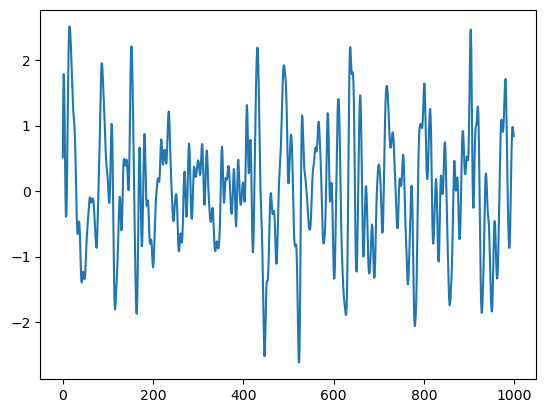

In [16]:
#plt.plot(diff_eeg[0:1000, 37])
plt.plot(eeg_orig[0:1000, 37])
#plt.plot(pred_eeg[0:1000, 37])


Compare with onsets

In [17]:
sv_to_test = ['firsts', 'firsts_sur', 'onsets_sur', 'fo_sur']
#sv_to_test = ['firsts']
r_data = []

for subject in ['08']:
    print(f'processing {subject}')

    r_sub = {
        'subject':subject,
        'period': period
    }

    sv, eeg = load_stim_resp(subject, period, n_segments, eeg_dir, sv_dir, stim_sv='onsets') #load stim

    
    #load model and predict on onset only
    fwd_trf = load_trf_model(subject, period, mTRF_path)
    _, pred_metric = find_fwd_trf_preds(fwd_trf, sv, eeg)
    r_sub['onset'] = pred_metric

    for sv_type in sv_to_test:
        sv, eeg = load_stim_resp(subject, period, n_segments, eeg_dir, sv_dir, stim_sv=sv_type) #load stim

        
        #load model and predict
        fwd_trf = load_trf_model(subject, period, mTRF_path)
        _, pred_metric = find_fwd_trf_preds(fwd_trf, sv, eeg)

        #save predictions
        r_sub[sv_type] = pred_metric
    
    r_data.append(r_sub)

r_df = pd.DataFrame(r_data)


processing 08


In [18]:
r_df

,subject,period,onset,firsts,firsts_sur,onsets_sur,fo_sur
0,08,pre,0.113475,0.113378,0.069024,0.098534,0.063455


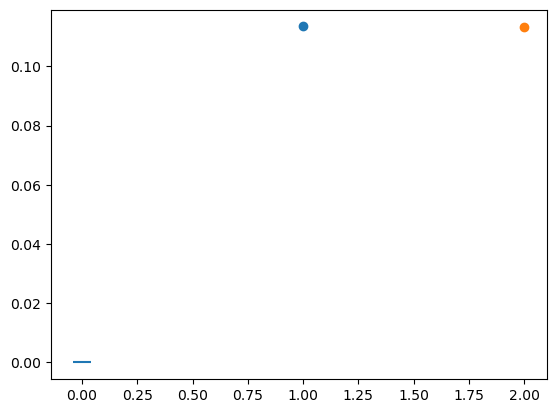

In [19]:
#plt.scatter(np.zeros_like(r_df['firsts_diff']), r_df['firsts_diff'])
plt.scatter(np.full_like(r_df['onset'], 1), r_df['onset'])
plt.scatter(np.full_like(r_df['firsts'], 2), r_df['firsts'])
plt.hlines(0, -0.04, 0.04)

### Compute predictions only

In [20]:
fwd_pred_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/fTRF_predictions'

In [44]:
def eeg_to_numpy(eeg_dir, task, subject, period, normalize = False):


    data_err = loadmat(os.path.join(eeg_dir, f'{subject}/eeg_{task}_{period}_{subject}.mat'))
    eeg_err = data_err['trial_data'].T

    if normalize: 
        eeg_err = normalize_responses_2([eeg_err])[0] #gets it out of the list

    return eeg_err


eeg_orig = eeg_to_numpy(eeg_dir, 'error', subject, period, normalize = False)

In [59]:
sv_to_pred = ['onsets','firsts']

for subject in subjects_to_process:
    print(f'processing {subject}')

    for sv_type in sv_to_pred:
    
        sv, eeg = load_stim_resp(subject, period, n_segments, eeg_dir, sv_dir, stim_sv=sv_type) #load stim

        #load model and predict on onset only
        fwd_trf = load_trf_model(subject, period, mTRF_path)
        pred_eeg, pred_metric = find_fwd_trf_preds(fwd_trf, sv, eeg, normalize= False)

        #rereference the predicted eeg
        pred_eeg = normalize_responses([pred_eeg])[0]

        pred_data = {
            'pred_eeg': pred_eeg,
            'pred_metric': pred_metric
        }
        
        savemat(os.path.join(fwd_pred_path,f'preds_err_{sv_type}_{subject}_{period}.mat'), pred_data)
        


processing 01
processing 04
processing 05
processing 06
processing 07
processing 08
processing 09
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20


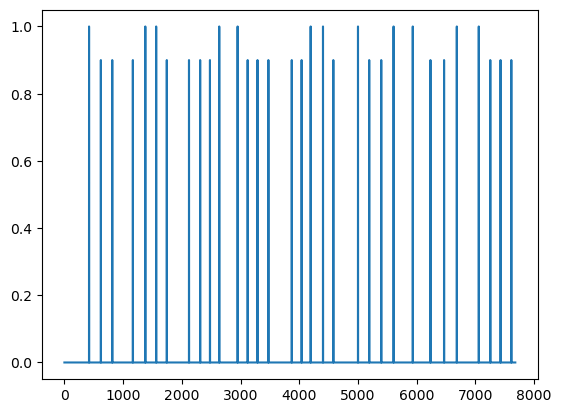

In [32]:
plt.plot(sv[0])

In [109]:
corr_data = []
sv_to_test = ['firsts']
ch_idx = ch_index(['Fz', 'FCz', 'Cz', 'F1', 'FC1', 'C1', 'C2', 'FC2', 'F2'])
period = 'pre'

for subject in subjects_to_process:
    print('processing sub', subject)

    # try:
    sub_data = {
        'subject':subject,
        'period':period
    }
    
    eeg_orig = eeg_to_numpy(eeg_dir, 'error', subject, period, normalize = True)

    #eeg_orig = winsorize(eeg_orig, [0.005, 0.005])
    
    eeg_pred = loadmat(os.path.join(fwd_pred_path,f'preds_err_onsets_{subject}_{period}.mat'))['pred_eeg']

    
    if eeg_pred.shape[0] != eeg_orig.shape[0]:
        smaller = np.min([eeg_pred.shape[0], eeg_orig.shape[0]])
        if smaller == eeg_pred.shape[0]:
            eeg_orig = eeg_orig[:eeg_pred.shape[0], :]
        elif smaller == eeg_orig.shape[0]:
            eeg_pred = eeg_pred[:eeg_orig.shape[0], :]

    print(eeg_pred.shape, eeg_orig.shape)
    corr_all_o = np.array([pearsonr(eeg_pred[:, ch], eeg_orig[:, ch])[0] for ch in ch_idx])
    corr_o = np.mean(corr_all_o)


    sub_data['onset'] = corr_o
    sub_data['diff_onset'] = np.abs((eeg_pred-eeg_orig).mean())

    for sv_type in sv_to_test:
        eeg_orig = eeg_to_numpy(eeg_dir, 'error', subject, period, normalize = True)
        eeg_pred = loadmat(os.path.join(fwd_pred_path,f'preds_err_{sv_type}_{subject}_{period}.mat'))['pred_eeg']
        
        if eeg_pred.shape[0] != eeg_orig.shape[0]:
            smaller = np.min([eeg_pred.shape[0], eeg_orig.shape[0]])
        if smaller == eeg_pred.shape[0]:
            eeg_orig = eeg_orig[:eeg_pred.shape[0], :]
        elif smaller == eeg_orig.shape[0]:
            eeg_pred = eeg_pred[:eeg_orig.shape[0], :]

        corr_all_f = np.array([pearsonr(eeg_pred[:, ch], eeg_orig[:, ch])[0] for ch in ch_idx])
        corr_f = np.mean(corr_all_f)

        sub_data[sv_type] = corr_f
        sub_data['diff_'+sv_type] = np.abs((eeg_pred-eeg_orig).mean())

    corr_data.append(sub_data)
    # except ValueError:
    #     print('indexing issue in sub', subject)
    #     continue

corr_df = pd.DataFrame(corr_data)


processing sub 01
(55880, 64) (55880, 64)
processing sub 04
(23440, 64) (23440, 64)
processing sub 05
(76800, 64) (76800, 64)
processing sub 06
(76800, 64) (76800, 64)
processing sub 07
(76800, 64) (76800, 64)
processing sub 08
(76800, 64) (76800, 64)
processing sub 09
(76800, 64) (76800, 64)
processing sub 10
(76800, 64) (76800, 64)
processing sub 11
(76800, 64) (76800, 64)
processing sub 12
(76800, 64) (76800, 64)
processing sub 13
(76800, 64) (76800, 64)
processing sub 14
(76800, 64) (76800, 64)
processing sub 15
(76800, 64) (76800, 64)
processing sub 16
(76800, 64) (76800, 64)
processing sub 17
(76800, 64) (76800, 64)
processing sub 18
(76800, 64) (76800, 64)
processing sub 19
(76800, 64) (76800, 64)
processing sub 20
(76800, 64) (76800, 64)


In [110]:
corr_df['diff_fo_abs'] = corr_df['diff_firsts'] - corr_df['diff_onset']
corr_df['diff'] = corr_df['firsts'] - corr_df['onset']

In [111]:
corr_df

,subject,period,onset,diff_onset,firsts,diff_firsts,diff_fo_abs,diff
0,01,pre,0.107439,3.091085e-05,0.108269,3.091085e-05,-7.162511e-18,0.000830
1,04,pre,0.014416,2.229596e-05,0.013646,2.229596e-05,2.347975e-18,-0.000770
2,05,pre,0.139750,4.836409e-17,0.143375,2.137179e-17,-2.699230e-17,0.003625
3,06,pre,0.116639,1.165734e-17,0.117573,9.066821e-18,-2.590520e-18,0.000934
4,07,pre,0.098806,7.991293e-18,0.098765,2.964064e-17,2.164935e-17,-0.000041
5,08,pre,0.168149,1.188864e-17,0.167857,1.323016e-17,1.341519e-18,-0.000292
6,09,pre,0.208389,7.771561e-18,0.207733,4.996004e-18,-2.775558e-18,-0.000656
7,10,pre,0.073932,4.070818e-18,0.073714,3.034610e-17,2.627528e-17,-0.000219
8,11,pre,0.077531,3.145632e-17,0.078842,2.488750e-17,-6.568820e-18,0.001310
9,12,pre,0.000626,1.261722e-17,0.000418,9.564109e-18,-3.053113e-18,-0.000209


In [112]:
wilcoxon_1samp(corr_df['diff_fo_abs'])

WilcoxonResult(statistic=50.0, pvalue=0.12973785400390625)

In [79]:
#load predicted and original data
subject = '09'
sv_type = 'firsts'
eeg_orig = eeg_to_numpy(eeg_dir, 'error', subject, 'pre', normalize = True)
eeg_pred = loadmat(os.path.join(fwd_pred_path,f'preds_err_{sv_type}_{subject}_{period}.mat'))['pred_eeg']


In [87]:
eeg_pred_onsets = loadmat(os.path.join(fwd_pred_path,f'preds_err_onsets_{subject}_{period}.mat'))['pred_eeg']
eeg_pred_firsts = loadmat(os.path.join(fwd_pred_path,f'preds_err_firsts_{subject}_{period}.mat'))['pred_eeg']

In [88]:
eeg_diff_o = eeg_pred_onsets - eeg_orig
eeg_diff_f = eeg_pred_firsts - eeg_orig

In [89]:
eeg_diff_o.mean()

7.771561172376097e-18

In [90]:
eeg_diff_f.mean()

4.996003610813204e-18

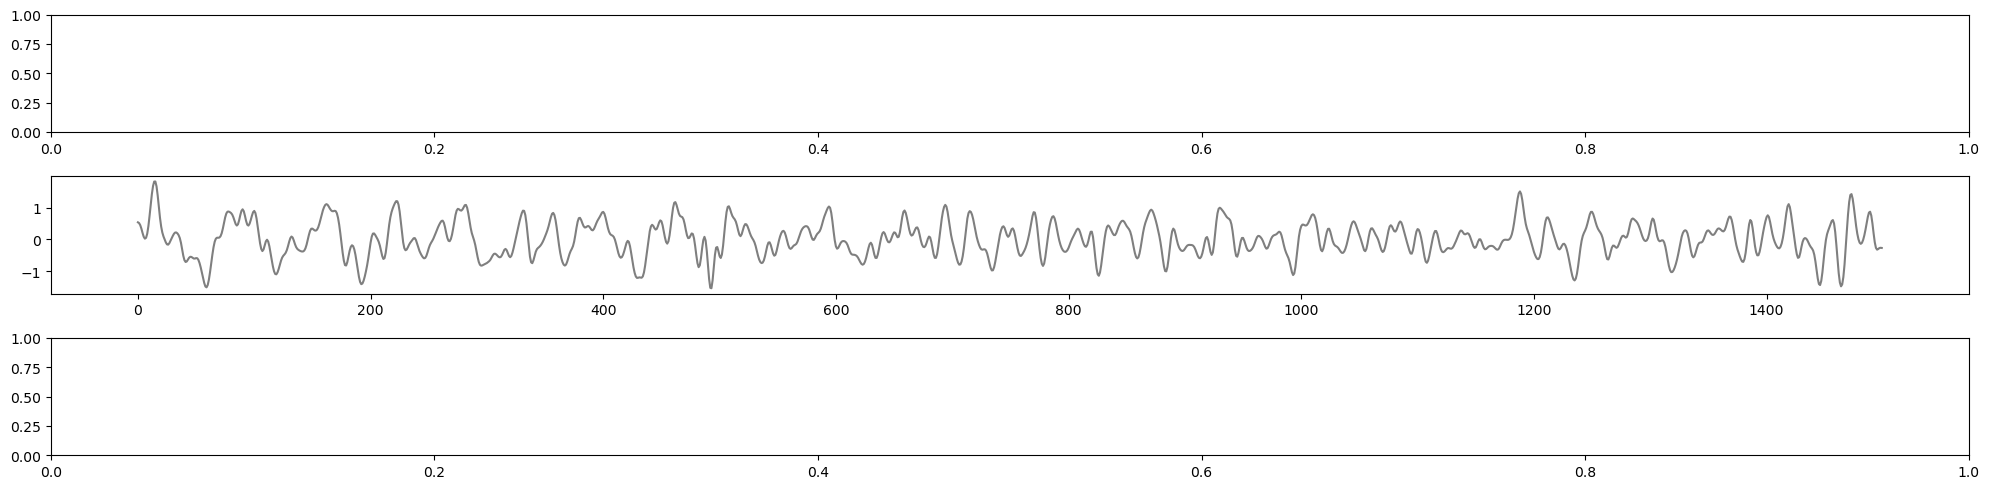

In [122]:
fig, ax = plt.subplots(3,1,figsize=(20,5))
#ax[0].plot(eeg_pred[0:4000, 37], color = 'black', alpha = 0.5, label = 'predicted EEG')
ax[1].plot(eeg_orig[1500:3000, 37], color = 'black', alpha = 0.5, label = 'real EEG')
#ax[2].plot(eeg_diff_f[0:4000, 37], alpha = 0.5, label = 'difference')
plt.tight_layout()

plt.savefig('eeg.svg')

Compare predictions with certain channels

Compare with shuffled firsts

In [339]:
#sv_to_test = ['firsts', 'firsts_sur', 'onsets_sur', 'fo_sur']
sv_to_test = ['firsts']
r_data = []

for subject in subjects_to_process:
    print(f'processing {subject}')

    r_sub = {
        'subject':subject,
        'period': period
    }
    
    for sv_type in sv_to_test:

        #unshuffled
        sv, eeg = load_stim_resp(subject, period, n_segments, eeg_dir, sv_dir, stim_sv=sv_type, shuffle = False) #load stim

        #load model and predict
        fwd_trf = load_trf_model(subject, period, mTRF_path)
        _, pred_metric = find_fwd_trf_preds(fwd_trf, sv, eeg)
        #save predictions
        r_sub[sv_type] = pred_metric

        #shuffled
        sv, eeg = load_stim_resp(subject, period, n_segments, eeg_dir, sv_dir, stim_sv=sv_type, shuffle = True)

        fwd_trf = load_trf_model(subject, period, mTRF_path)
        _, pred_metric = find_fwd_trf_preds(fwd_trf, sv, eeg)
        r_sub[sv_type+'_shuffled'] = pred_metric

    
    r_data.append(r_sub)

r_df = pd.DataFrame(r_data)


processing 01
processing 04
processing 05
processing 06
processing 07
processing 08
processing 09
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20


In [340]:
r_df['diff'] = r_df['firsts'] - r_df['firsts_shuffled']
r_df

,subject,period,firsts,firsts_shuffled,diff
0,01,pre,0.092525,0.092347,0.000178
1,04,pre,0.003577,0.004232,-0.000655
2,05,pre,0.101357,0.099679,0.001678
3,06,pre,0.069709,0.069360,0.000349
4,07,pre,0.072322,0.072294,0.000028
5,08,pre,0.112725,0.112846,-0.000121
6,09,pre,0.133017,0.133229,-0.000212
7,10,pre,0.044109,0.044240,-0.000131
8,11,pre,0.060978,0.060000,0.000978
9,12,pre,0.001060,0.001377,-0.000318


In [341]:
wilcoxon_1samp(r_df['diff'])

WilcoxonResult(statistic=71.0, pvalue=0.550872802734375)

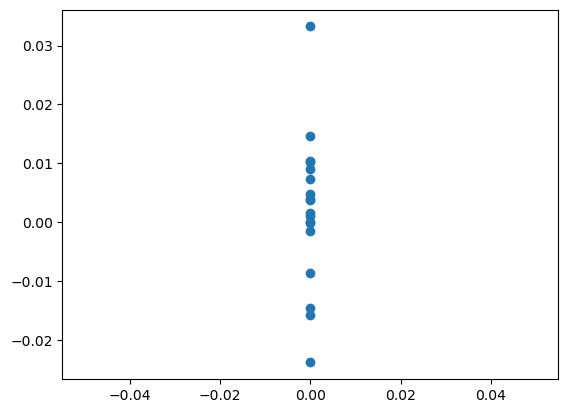

In [337]:
plt.scatter(np.zeros_like(r_df['diff']), r_df['diff'])

Compare with shuffled onsets

processing 08


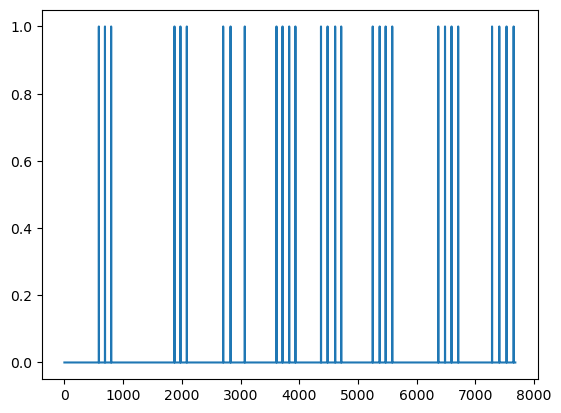

In [280]:
#sv_to_test = ['firsts', 'firsts_sur', 'onsets_sur', 'fo_sur']
sv_to_test = ['firsts']
r_data = []

for subject in ['08']:
    print(f'processing {subject}')

    r_sub = {
        'subject':subject,
        'period': period
    }
    sv, eeg = load_stim_resp(subject, period, n_segments, eeg_dir, sv_dir, stim_sv='onsets') #load stim
    
    
    #load model and predict on onset only
    fwd_trf = load_trf_model(subject, period, mTRF_path)
    _, pred_metric = find_fwd_trf_preds(fwd_trf, sv, eeg)
    r_sub['onset'] = pred_metric

    #load model and predict on onset only
    np.random.shuffle(sv)
    plt.plot(sv[0])
    _, pred_metric = find_fwd_trf_preds(fwd_trf, sv, eeg)

    r_sub['onset_shuffled'] = pred_metric
    
    r_data.append(r_sub)

r_df = pd.DataFrame(r_data)


In [273]:
r_df_new = r_df.melt(id_vars=['subject', 'period'],
          value_vars=['onset', 'onset_shuffled'],
          var_name='type',
          value_name='corr')

In [271]:
import seaborn as sns

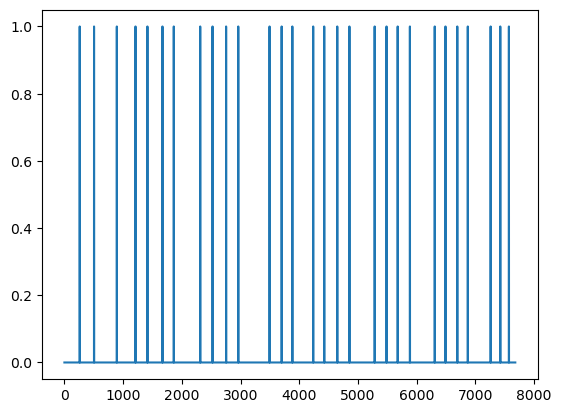

In [278]:
plt.plot(sv[0])

<Axes: xlabel='type', ylabel='corr'>

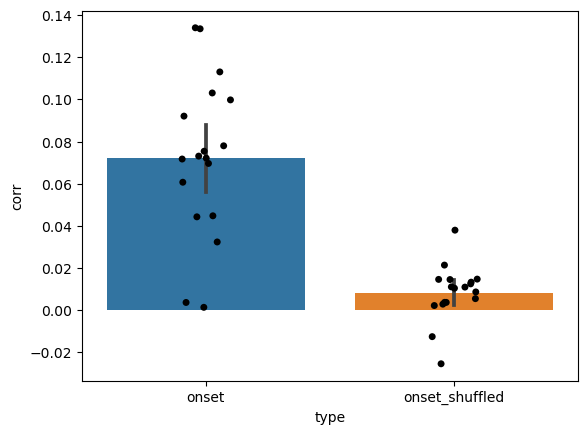

In [276]:
sns.stripplot(data = r_df_new, x = 'type', y = 'corr', color = 'black')
sns.barplot(data = r_df_new, x = 'type', y = 'corr')